# Indice
* [Neural Network](#Neural-Network)
	* [Caso di studio](#Caso-di-studio)
		* [Codice utlizzato per la Neural Network applicato al  nostro caso di studio](#Codice-utlizzato-per-la-Neural-Network-applicato-al--nostro-caso-di-studio)
			* [Considerazioni](#Considerazioni)
		* [Codice utlizzato per la Deep Neural Network applicato al  nostro caso di studio](#Codice-utlizzato-per-la-Deep-Neural-Network-applicato-al--nostro-caso-di-studio-[5]%28#cite-DBLP:journals/corr/SimonyanZ14a%29)
			* [Considerazioni](#Considerazioni)


# Neural Network

Le **Artificial Neural Network**, (_NN_) sono modelli matematici largamente utilizzati nel campo dell'**Intelligenza Artificiale** (_AI_) che permettono, a sistemi automatici, di compiere task complessi e articolati che dei semplici algoritmi (es. algoritmi sequenziali) non sarebbero in grado di portare a termine in modo rapido ed efficace.

Le basi di questo metodo risalgono alla metà del XX secolo quando per la prima volta furono proposti algoritmi per l'apprendimento automatico. L'obiettivo era quello di creare _strutture_ in grado di modellare un determinato fenomeno e riproporne il comportamento in determinate condizioni.

Il componente base di questa nuova struttura è il _**neurone**_. Con questo termine identifichiamo un nodo in grado di simulare il comportamento di un neurone biologico e di interconnettersi con altri neuroni al fine di creare una rete. Ogni nodo elabora i segnali ricevuti e trasmette il risultato a nodi successivi.

Un tipico esempio di struttura base di queste reti è il **percettrone**:
![Percettrone](./img/percetrone.png)

Ogni singolo ingresso di questi nodi riceve informazioni che vengono elaborate. L'elaborazione, che in base agli ingressi può diventare complessa, si può pensare come singoli ingressi che vengono moltiplicati per un opportuno valore detto peso. Il risultato ottenuto delle moltiplicazioni viene sommato e se la somma supera una certa soglia il neurone attiva la sua uscita. Il peso serve a quantificare l'importanza di una interconnessione, infatti un ingresso molto importante avrà un peso elevato, mentre un ingresso poco utile all'elaborazione avrà un peso inferiore.

Ponendo in cascata e combinando tra loro più più neuroni generiamo quella che definiamo _NN_.
![ANN](./img/ann.png)

L'utilizzo delle NN è tornato in uso dopo la reinvenzione dell’algoritmo di apprendimento chiamato back-propagation. Questo algoritmo infatti permette di modificare i pesi delle interconnessioni in modo tale che si minimizzi una certa funzione errore E.

Con l'avvento di nuove metodologie come il **machine learning** e l'aumento della performance delle NN il campo dell'intelligenza artificiale è diventato tra i più importanti ambiti di ricerca nella computer scienze. Grazie a questo, i risultati e i campi applicativi acquisiscono, di giorno in giorno, maggiore interesse. Siamo così passati ad analizzare, attraverso le _NN_, problemi sempre più complessi: è l'avvento del **deep learning**.

Nelle reti neurali classiche moderne è possibile riscontrare la presenza di qualche strato nascosto. Questi strati, denominati _hidden layers_, possono essere interpretati come il _cuore_ della rete stessa poiché sono quelli che si occupano di interpretare le features sottomesse alla rete.

![NN](./img/simple_neural_network_header.jpg)

Con il deep learning, invece, siamo rapportati a problemi più complessi: _dal riconoscimento ed interpretazione del linguaggio naturale fino alla visione artificiale_. Nei modelli deep ogni singolo stato nascosto potrebbe essere paragonato ad una piccola rete neurale classica: ponendone in cascata una all'altra possiamo ottenere modelli complessi per la gestione di task anche molto avanzati come ad esempio gli algoritmi di visione per l'_automotive_

![deep](./img/deep.png)

## Caso di studio

### Codice utlizzato per la Neural Network applicato al  nostro caso di studio

Il nostro dataset è composto da 3815 elementi ognuno dei quali è descritto attraverso 31 features. In questo primo approccio viene mostrato come addestrare una rete neurale classica sia attraverso la classica strarificazione per determinare dataset di training e test, sia con la cross validation.

In [ ]:
# standard libraries
import os
import shutil
import numpy as np
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout
# keras libraries
from keras.models import Sequential
from keras.models import load_model
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
# sklearn libraries
from sklearn.model_selection import train_test_split

# convolutional network params
path_dataset = './dataset/dataset_total.txt'  # datasetpath
path_best = './best_model/'  # kfolds model path
path_thebest = './thebetter_model/'  # bset models path

# neural network params
batch_size = 32  # training cases batch
num_epochs = 500  # max number of epochs
num_classes = 3  # number of class in dataset
seed = 42  # base random seed
n_splits = 10  # number of kfold
n_input_layer = 31 # number of inputs layer

Using TensorFlow backend.


Definiamo la funzione utile per il caricamento del dataset e il suo _splitting_ in porzione di test e di training. La strategia adottata è quella della stratificazione: creare due insiemi nei quali la "_concentrazione_" dei vari esempi sia equipollente. Ad esempio, se nel dataset di training ci sono il 30% dei campioni di tipo 1 il 40% di tipo 2 e 30% dei campioni di tipo 3, le stesse percentuali saranno adottate per il dataset di test.

In [2]:
def load_data_nn():
    """
    generate dataset based on data in dataset folder
    :return: train and test dataset based on stratification strategy
    """
    dataset = np.loadtxt(path_dataset, delimiter='\t')

    y = np.array(np.ceil(dataset[:, -1])).astype(np.str)
    X = np.array(dataset[:, :-1]).astype(np.float32)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed, stratify=y)

    scaler = preprocessing.StandardScaler().fit(x_train)

    X_train = scaler.transform(x_train)
    X_test = scaler.transform(x_test)

    y_train = np.subtract(y_train.reshape((len(y_train), 1)).astype(np.float32), np.asarray(2.0))
    y_test = np.subtract(y_test.reshape((len(y_test), 1)).astype(np.float32), np.asarray(2.0))

    Y_train = np_utils.to_categorical(y_train, num_classes)
    Y_test = np_utils.to_categorical(y_test, num_classes)
    return X_train, X_test, Y_train, Y_test

Definiamo la funzione che instanzierà il modello della nostra rete neurale. La struttura segue i seguenti parametri:
 - primo livello di ingresso con 31 neuroni. Idealmente sarebbero 1 per ciascuna features.
 - 4 livelli nascosti con lo stesso numero di neuroni e funzione di attivazione _elu_ [6](#cite-DBLP:journals/corr/ClevertUH15).
 - 4 livelli di _Dropout_, ciascuno dopo ogni livello nascosto.
 - ultimo livello con 3 neuroni e _softmax_ come funzione di attivazione.
 - la funzione di perdita da minimizzare è la _binary_crossentropy_ attraverso l'ottimizzazione _adadelta_.
 
 ![elu](https://smist08.files.wordpress.com/2017/10/screen-shot-2017-10-16-at-1-54-31-pm.png?w=300&h=205)

In [3]:
def baseline_model():
    """
    Definition of neural network base model
    :return: model
    """
    base_model = Sequential()
    base_model.add(Dense(n_input_layer, activation='elu',  input_shape=(X_train.shape[1],)))
    #hidden
    base_model.add(Dense(31, activation='elu'))
    base_model.add(Dropout(0.1))
    base_model.add(Dense(31, activation='elu'))
    base_model.add(Dropout(0.1))
    base_model.add(Dense(31, activation='elu'))
    base_model.add(Dropout(0.1))
    base_model.add(Dense(31, activation='elu'))
    base_model.add(Dropout(0.3))
    base_model.add(Dense(3, activation='softmax'))
    base_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
    return base_model

Definiamo una funzione per la valutazione del modello migliore in uscita dal processo di addestramento in cross validation

In [4]:
def evaluete_nn(X_test, Y_test, best_model=None, model=None):
    """
    Evaluate best model after kfold training
    :param X_test: example images to test best model after kfold
    :param Y_test: labels matching truth to example
    :param best_model: index which identify best model after kfold
    :return: evaluation of best model trough dataset test and save it with loss and accuracy metrics
    """

    # load best model and evaluate it with accuracy and loss
    if(model==None):
        print('Load best model and test it ')
        model = load_model(path_best+'checkpoint-%d.h5' %(best_model))
    score = model.evaluate(X_test, Y_test, verbose=0)  # evaluate model
    y_predict = np.asarray(model.predict(X_test, verbose=0))
    Y_predict = np.argmax(y_predict, axis=1)
    y_test = np.argmax(Y_test, axis=1)
    confmatrix = confusion_matrix(y_test, Y_predict)
    print("\nConfusion Matrix :")
    print(confmatrix)
    class_names = ["0", "1", '2']
    print("\nMetrics => ", model.metrics_names, score)
    print('\nClassification Report : ')
    print(classification_report(y_test, Y_predict, target_names=class_names))
    # save model tested with loss and accuracy
    model.save(path_thebest+'model-'+'{:.4f}'.format(score[0])+'-'+'{:.4f}'.format(score[1])+'.h5')

In [5]:
print('STARTING FITTING NEURAL NETWORK')
if os.path.exists(path_best):
    shutil.rmtree(path_best)
os.mkdir(path_best)
if not os.path.exists(path_thebest):
    os.mkdir(path_thebest)

print('loading data .......\n')
X_train, X_test, Y_train, Y_test = load_data_nn()

print('train examples:')
print(len(X_train))
print('test examples:')
print(len(X_test))


STARTING FITTING NEURAL NETWORK
loading data .......

train examples:
2670
test examples:
1145


Addestriamo inizialmente la rete neurale senza sfruttare la cross validation. Imponiamo un numero massimo di iterazioni pari a 500. Poiché, a causa dello sbilanciamento del dataset, incorreremo sicuramente in overfitting per gli elementi di appartenenza alla classe _low_risk_, imponiamo anche un **EarlyStopping**, ovvero un listener che monitora l'andamento della funzione di perdita che stiamo minimizzando e, se questa non dovesse avere variazioni pari ad un delta di _0.001_ per più di 10 iterazioni, blocchi l'addestramento della rete se necessario.

In [6]:
model = baseline_model()
model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, verbose=1,
          callbacks=[TensorBoard(log_dir='./nn/tensorboard/'),
                     EarlyStopping(monitor='loss', min_delta=0.001, patience=10, verbose=2, mode='min')])
scores = model.evaluate(X_train, Y_train, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/500
2670/2670 [==============================] - 0s 102us/step - loss: 0.4005 - acc: 0.8341
Epoch 2/500
2670/2670 [==============================] - 0s 55us/step - loss: 0.1504 - acc: 0.9546
Epoch 3/500
2670/2670 [==============================] - 0s 65us/step - loss: 0.1311 - acc: 0.9579
Epoch 4/500
2670/2670 [==============================] - 0s 89us/step - loss: 0.1267 - acc: 0.9546
Epoch 5/500
2670/2670 [==============================] - 0s 64us/step - loss: 0.1172 - acc: 0.9627
Epoch 6/500
2670/2670 [==============================] - 0s 56us/step - loss: 0.1160 - acc: 0.9593
Epoch 7/500
2670/2670 [==============================] - 0s 59us/step - loss: 0.1151 - acc: 0.9584
Epoch 8/500
2670/2670 [==============================] - 0s 60us/step - loss: 0.1110 - acc: 0.9576
Epoch 9/500
2670/2670 [==============================] - 0s 66us/step - loss: 0.1043 - acc: 0.9619
Epoch 10/500
2670/2670 [==============================] - 0s 57us/step - loss: 0.1103 - acc: 0.9597
Epoch 11

Valutiamo ora le performance del modello addestrato sul dataset di test

In [7]:
evaluete_nn(X_test, Y_test, model=model)


Confusion Matrix :
[[1077    1    0]
 [  15    7    4]
 [  33    0    8]]

Metrics =>  ['loss', 'acc'] [0.10068720200436605, 0.96826783345776357]

Classification Report : 
             precision    recall  f1-score   support

          0       0.96      1.00      0.98      1078
          1       0.88      0.27      0.41        26
          2       0.67      0.20      0.30        41

avg / total       0.95      0.95      0.94      1145



Passando all'utilizzo della cross validation, utilizziamo per la rete la stessa accortezza utilizzata in precedenza con **EarlyStopping**, in più imponiamo che, per ogni *k\_fold*, venga salvato il miglior modello in un path specifico. Assieme al modello salviamo, per ciasun *best\_model*, i rispettivi valori di _accurancy_ in un vettore (_**cvscores**_). In questo modo, alla fine dell'iterazione dei vari k_fold, possiamo selezionare il *better\_model* da valutare con il dataset di test.
Il risultato finale fornisce anche un valore di media per l'accuratezza valutata su tutti i modelli risultati migliori per ciascun k_fold.

In [8]:
# generation kfolds to cross validation process
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
cvscores = []
i = 0

# start cross validation
for train, test in kfold.split(X_train, Y_train):
    model = baseline_model()
    model.fit(X_train[train], Y_train[train], epochs=num_epochs, batch_size=batch_size, verbose=0,
              callbacks=[TensorBoard(log_dir='./nn/tensorboard/'),
                         ModelCheckpoint(path_best+'checkpoint-%d.h5' %(i), monitor='acc', verbose=0,
                                         save_best_only=True, mode='max'),
                         EarlyStopping(monitor='loss', min_delta=0.001, patience=10, verbose=2, mode='min')])
    scores = model.evaluate(X_train[test], Y_train[test], verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    i += 1
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Epoch 00058: early stopping
acc: 96.63%
Epoch 00055: early stopping
acc: 97.00%
Epoch 00039: early stopping
acc: 96.00%
Epoch 00037: early stopping
acc: 96.13%
Epoch 00051: early stopping
acc: 96.75%
Epoch 00072: early stopping
acc: 96.13%
Epoch 00059: early stopping
acc: 94.76%
Epoch 00076: early stopping
acc: 96.75%
Epoch 00058: early stopping
acc: 96.88%
Epoch 00043: early stopping
acc: 96.88%
96.39% (+/- 0.64%)


A questo punto è opportuno valutare il miglior modello tra quelli risultati ottimali per ciascun k_fold.

In [9]:
# evaluate best model based on higher accuracy
vect_max = np.argmax(cvscores)
evaluete_nn(X_test, Y_test, best_model=vect_max)

Load best model and test it 

Confusion Matrix :
[[1066    0   12]
 [  15    7    4]
 [  26    1   14]]

Metrics =>  ['loss', 'acc'] [0.097809638701151558, 0.96535662974853187]

Classification Report : 
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      1078
          1       0.88      0.27      0.41        26
          2       0.47      0.34      0.39        41

avg / total       0.94      0.95      0.94      1145



##### Considerazioni

Analizzando le metriche base di entrambi i casi di addestramento, possiamo notare che gli andamenti sono pressoché uguali, con una precisione del 96%. Il dato che ci consente di percepire che l'addestramento effettuato con la cross validation sia in qualche modo migliore, ci viene fornito dal report dalla confusion matrix: nel primo caso, si nota chiaramente che il modello soffre di overfitting per la classe 0 e non ha ottimi riscontri per gli elementi di classe 2 (in questo caso ha una precisione al di sotto del 60%); mentre per la classe 1, nonostante una precisione molto alta, la recall è molto bassa addirittura sotto il 20%.

Nel caso di addestramento con la tecnica della cross validazione, benché non possiamo dirci del tutto fuori dal fenomeno di overfitting, possiamo notare una migliore precisione per gli elementi di classe 1 e classe 2. In questo caso siamo oltre il valore di 80% percento per la classe 2, e di poco sotto il 90% per la classe 1. Anche in questo caso la recall per queste due classi è molto bassa, indice chiaro di una forte tendenza verso l'overfitting.

L'utilizzo della cross validation, per evitare o attenuare il fenomeno di overfitting sul modello, è stato dettato dal voler rendere il modello il più vicino possibile al _mondo reale_. Infatti, avremmo potuto utilizzare tecniche di _**data augumentation**_ [7](#cite-DBLP:journals/corr/WongGSM16) per creare esempi _artificiali_ della classe 1 e della classe 2, avremmo però reso il modello fittizio e molto lontano dal caso reale nel quale dovrebbe agire.

### Codice utlizzato per la Deep Neural Network applicato al  nostro caso di studio [5](#cite-DBLP:journals/corr/SimonyanZ14a)

Un altro approccio che abbiamo utilizzato è quello basato su tecniche di deep learning. In questo caso abbiamo sfruttato il dataset di immagini che ci è stato fornito. Attraverso i passaggi di _preprocessing_ visti in precedenza, abbiamo generato circa 6000 immagini binarie suddivise secondo le 3 categorie di pericolosità.

Analizzando il risultato di questi step, abbiamo rilevato che alcuni esempi erano ripetuti in classi diverse, e quindi abbiamo proceduto ad una prima scrematura basata sulla somiglianza di alcune immagini. Dopo questo passaggio abbiamo ottenuto il dataset completo con circa 5000 esempi.

Questa osservazione ci ha condotto a fare una riflessione circa la correttezza della classificazione proposta, e ci ha spinto ad effettuare una riassegnazione dei vari esempi rispetto alle classi di appartenenza con una rete non supervisionata.

I test che mostreremo di seguito mostrano come addestrare una _**CNN**_ (convolutional neural network) nel nostro caso di studio.

L'utilizzo di _CNN_ per affrontare problemi di _image vision_ è largamente documentata in letteratura, anche nel caso di immagini _SAR_ [1](#cite-7326627) [2](#cite-7326163) [3](#cite-KERAMITSOGLOU2006640). Nel nostro caso specifico, tuttavia, non sfruttiamo l'apporto radiometrico di tali immagini, ma ne sfruttiamo solo l'aspetto morfologico.

In [5]:
# base libraries
import os
import shutil
import itertools

import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import skimage.measure
from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
# keras import
from keras.models import Sequential
from keras.models import load_model
from keras.utils import np_utils
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from sklearn.metrics import confusion_matrix, classification_report
# sklearn import
from sklearn.model_selection import train_test_split

# path to save files
path_dataset = './crop_r'  # dataset path
path_model = './model/'  # path to save model
path_board = './tensorboard'

# convolutional network parmas
batch_size = 64  # training cases batch
num_epochs = 500  # max number of epochs
kernel_size = 3  # kernel size dimension
pool_size = 2  # max pooling size
seed = 42  # base random seed

# dataset image parameters
height = 32
width = 32
depth = 1

Defiamo la funzione *load\_data\_cnn* che ci consente di generare il dataset di training e di test a partire dalle immagini presenti nel path indicato. In questo caso imponiamo che il 30% dell'intero dataset verrà sfruttato per il test. Anche in questo caso, come per il precedente, utilizziamo la tecnica della _stratificazione_ per generare i due dataset.

Una volta generato i dataset di training e test basati sui _file path_ delle immagini, procediamo alla _risoluzione_ di questi path in modo da generare il training set ed il test set con le immagini. Per fare questo sfruttiamo il metodo *load\_image*, in grado di restituire l'immagine associata ad uno specifico path ed effettuare il _reshape_ propedeutico per l'utilizzo nella nostra rete convoluzionale.

Per questo tipo di classificazione è opportuno, sia per le label del training set che per il test set, sfruttare la tecnica del _one hot encoding_. Con questo tipo di processamento, le label, sono trasfomate in vettori di lunghezza _N_ (con _N_ pari al numero di classi) e riportano il valore _1_ rispetto all'indice della classe di appartenenza mentre negli altri casi i valori del vettore sono a _0_. Per applicare questa tecnica abbiamo rimappato le classi come segue:
 - classe 2 (low risk) ---------> classe 0
 - classe 3 (medium risk) ------> classe 1
 - classe 4 (high risk) --------> classe 2
 
In questo modo un esempio appartenente alla _classe 3_, rimappato con la _classe 1_, avrà una label di uscita pari a `[0 1 0]`, mentre un esempio di alto pericolo, rimappato con la _classe 2_, avrà una label uguale a `[0 0 1]`.
 

In [6]:
def load_data_cnn():

    filenames, labels = generate_dataset(path_dataset)
    x_train, x_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.30, 
                                                        random_state=seed, stratify=labels)
    X_train = np.asarray(load_image(x_train))
    X_test = np.asarray(load_image(x_test))
    num_classes = np.unique(y_train).shape[0]
    Y_train = np_utils.to_categorical(y_train, num_classes)
    Y_test = np_utils.to_categorical(y_test, num_classes)

    return X_train, X_test, Y_train, Y_test

def generate_dataset(base_path):
    """
    produce a dataset for neural network from path
    :param base_path: base path of dataset images
    :return: two array with file name and labels
    """
    filenames_array, labels_array = iterate_path(base_path)
    return filenames_array, labels_array

def iterate_path(path):
    """
    iterate path and sub path to generate an two array of images and labels
    :param path: base path to investigate
    :return: two array of file names and labels
    """
    filenames_array = []
    labels_array = []
    for root, dirs, files in os.walk(path):
        for name in files:
            filenames_array.append(os.path.join(root, name))
            labels_array.append(int(os.path.basename(os.path.normpath(root))))
    # labels_array = _one_hot_label(labels_array)
    return filenames_array, labels_array

def load_image(filenames):
    """
    load images from and array of path
    :param filenames: array of file names to load
    :return: an array of images
    """
    images = [*map(lambda x: np.asarray([read_image(x)]).reshape((32, 32, 1)), filenames)]
    return images

def read_image(filename):
    """
    load image from disk
    :param filename: path of images
    :return: image match to file name path
    """
    return mpimg.imread(filename)

Prepariamo una funzione in grado di valutare il modello addestrato. Questa, una volta caricato il modello addestrato, effettuerà la predizione sugli esempi di test e ne calcolerà la bontà di tale classificazione, fornendoci come output la _confusion matrix_ e un report della classificazione.

In [7]:
def evaluete_cnn(X_test, Y_test):

    model = load_model(path_model+'model.h5')

    score = model.evaluate(X_test, Y_test, verbose=1)  # Evaluate the trained model on the test set!

    y_predict = np.asarray(model.predict(X_test, verbose=0))
    Y_predict = np.argmax(y_predict, axis=1)
    y_test = np.argmax(Y_test, axis=1)
    confmatrix = confusion_matrix(y_test, Y_predict)
    print("\n Confusion Matrix :")
    print(confmatrix)
    class_names = ["0", "1", '2']

    print("\nMetrics => ", model.metrics_names, score)
    print('\nClassification Report : ')
    print(classification_report(y_test, Y_predict, target_names=class_names))

Definiamo ora il nostro modello. Abbiamo già anticipato che si tratta di una rete convoluzionale. Tipicamente questo tipo di configurazione prevede, per ogni strato nascosto, 3 livelli:
 1. livello di convoluzione
 2. livello di attivazione
 3. livello di pooling
 
![CNN_example](http://cs231n.github.io/assets/cnn/convnet.jpeg)

L'ultimo strato è tipicamente un _fully connected_ in grado di effettuare una predizione circa l'appartenenza di un esempio ad una classe piuttosto che ad un'altra.

Di seguito viene mostrato un esempio interattivo del livello di convoluzione. Abbiamo come input una matrice 5x5x3 alla quale è applicato, per ciascun livello, un padding +1 in modo da ottenere un volume di input pari a 7x7x3. A questo è applicata una convoluzione con due filtro di volume 3x3x3. La convoluzione è applicata con _stride_ pari a 2. Risulta facile calcolare la dimensionalità dell'uscita:

\begin{equation}
\frac{W−F+2P}{S}+1
\end{equation}

Nel nostro caso:

\begin{equation}
\frac{5−3+2}{2}+1=3
\end{equation}

In uscita avremo un volume pari a 3x3x2: la dimensione del filtro deriva dalla formula precedente, mentre la profondità è legata al numero di filtri.

In [8]:
from IPython.display import display, HTML
HTML('<iframe src="http://cs231n.github.io/assets/conv-demo" width="100%" height="700px;" style="border:none;"></iframe>')

Il nostro modello prevede 2 livelli di convoluzione entrambi con funzione di attivazione _elu_ e *max\_polling*. In cascata ad ogni livello di convoluzione abbiamo inserito un _dropout_ che rigetti il 25% dei casi in modo da rendere il modello meno prono all'overfitting e fornirgli un comportamento non lineare.

In coda ai due livelli di convoluzione viene effettuato un _reshape_ prima di passare i dati a due livelli *fully_connected* per la predizione tramite funzione di attivazione _softmax_.

In [9]:
model = Sequential()
conv_1 = Conv2D(32, kernel_size=(kernel_size, kernel_size), padding='same', input_shape=(height, width, depth),
                name='conv1')
model.add(conv_1)
convout1 = Activation('elu')
model.add(convout1)
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(kernel_size, kernel_size), padding='same', activation='elu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))


# compile model
model.compile(optimizer='adadelta',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
__________

In [10]:
print('STARTING FITTING CONVOLUTIONAL DEEP NEURAL NETWORK')
if not os.path.exists(path_model):
    os.mkdir(path_model)
if os.path.exists(path_board):
    shutil.rmtree(path_board)
os.mkdir(path_board)

print('loading data .......')
X_train, X_test, Y_train, Y_test = load_data_cnn()

print('train examples:')
print(len(X_train))
print('test examples:')
print(len(X_test))

STARTING FITTING CONVOLUTIONAL DEEP NEURAL NETWORK
loading data .......
train examples:
3690
test examples:
1582


Diamo inizio alla fase di training impostando anche in questo caso un **EarlyStopping** per evitare di stressare troppo il sitema verso l'overfitting.

In [16]:
# STARTING FITTING
print('start .... ')

model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=2, validation_split=0.1,
          callbacks=[TensorBoard(log_dir='./deep/tensorboard/', histogram_freq=1, write_images=True,
                                 write_grads=True, embeddings_layer_names=['conv1'], embeddings_freq=1),
                     EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2,
                                   verbose=1, mode='auto')])

# save current model
print("Saving model")
model.save(path_model+'model.h5', overwrite=True)

start .... 
Train on 3321 samples, validate on 369 samples
Epoch 1/500
 - 19s - loss: 0.3150 - acc: 0.9021 - val_loss: 0.2685 - val_acc: 0.9241
Epoch 2/500
 - 19s - loss: 0.2855 - acc: 0.9178 - val_loss: 0.2881 - val_acc: 0.9214
Epoch 3/500
 - 19s - loss: 0.2727 - acc: 0.9172 - val_loss: 0.2520 - val_acc: 0.9214
Epoch 4/500
 - 19s - loss: 0.2676 - acc: 0.9193 - val_loss: 0.2488 - val_acc: 0.9214
Epoch 5/500
 - 19s - loss: 0.2538 - acc: 0.9196 - val_loss: 0.2938 - val_acc: 0.9024
Epoch 6/500
 - 19s - loss: 0.2549 - acc: 0.9220 - val_loss: 0.2931 - val_acc: 0.9079
Epoch 00006: early stopping
Saving model


In [17]:
# evaluete model over test set
evaluete_cnn(X_test, Y_test)

1582/1582 [==============================] - 2s 1ms/step

 Confusion Matrix :
[[1434    3   16]
 [  28    0    1]
 [  88    2   10]]

Metrics =>  ['loss', 'acc'] [0.32986652598670402, 0.91276864713121453]

Classification Report : 
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      1453
          1       0.00      0.00      0.00        29
          2       0.37      0.10      0.16       100

avg / total       0.87      0.91      0.89      1582



Pare evidente che la rete abbia un problema di overfitting verso gli elementi di classe 0. La confusion matrix ci mostra come la predizione per gli esempi di classe 1 è praticamente inefficace e il risultati per quelli di classe 2 sono comunque poco confortanti.

Il problema del dataset, che avavamo già evidenziato in fase di preprocessing, influisce pesantemente sulle prestazioni della rete. A questo punto è lecito chiedersi: cosa succederebbe con un dataset meglio clusterizzato?

In [18]:
path_dataset = './img_cluster'

print('loading data .......')
X_train, X_test, Y_train, Y_test = load_data_cnn()

print('train examples:')
print(len(X_train))
print('test examples:')
print(len(X_test))

print('start .... ')

model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=2, validation_split=0.1,
          callbacks=[TensorBoard(log_dir='./deep/tensorboard/', histogram_freq=1, write_images=True,
                                 write_grads=True, embeddings_layer_names=['conv1'], embeddings_freq=1),
                     EarlyStopping(monitor='val_loss', min_delta=0.001, patience=2,
                                   verbose=1, mode='auto')])

# save current model
print("Saving model")
model.save(path_model+'model.h5', overwrite=True)
# evaluete model over test set
print("Evaluete model")
evaluete_cnn(X_test, Y_test)

loading data .......
train examples:
1152
test examples:
494
start .... 
Train on 1036 samples, validate on 116 samples
Epoch 1/500
 - 9s - loss: 0.6651 - acc: 0.6959 - val_loss: 0.7055 - val_acc: 0.7069
Epoch 2/500
 - 9s - loss: 0.4836 - acc: 0.7722 - val_loss: 0.7790 - val_acc: 0.6724
Epoch 3/500
 - 8s - loss: 0.3124 - acc: 0.8755 - val_loss: 0.5005 - val_acc: 0.8362
Epoch 4/500
 - 8s - loss: 0.3990 - acc: 0.8234 - val_loss: 0.5458 - val_acc: 0.7759
Epoch 5/500
 - 9s - loss: 0.2071 - acc: 0.9373 - val_loss: 0.4562 - val_acc: 0.8621
Epoch 6/500
 - 11s - loss: 0.2213 - acc: 0.9131 - val_loss: 0.4565 - val_acc: 0.9052
Epoch 7/500
 - 11s - loss: 0.2827 - acc: 0.8755 - val_loss: 0.9216 - val_acc: 0.6983
Epoch 00007: early stopping
Saving model
Evaluete model
494/494 [==============================] - 1s 2ms/step

 Confusion Matrix :
[[211  70   0]
 [  0 100  60]
 [  0   0  53]]

Metrics =>  ['loss', 'acc'] [0.64496924900091612, 0.73684210453921484]

Classification Report : 
             p

Analizzando le metriche e la confusion matrix, in questo caso, notiamo un netto miglioramento delle prestazioni, con un'accuratezza del 98%. Anche per gli esempi di classe 1 e classe 2 le performance sono nettamente migliorate. Tutto questo ci porta a concludere che le prestazioni della rete sono fortemente condizionate dal dataset in analisi.

Come ultimo passo mostriamo come la rete "vede" le immagini che sono le sono state passate. Siamo anche in grado di visualizzare i filtri sia del primo livello convoluzionale che del secondo [4](#cite-DBLP:journals/corr/HendersonR17).

In [11]:
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]

    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                           dtype=np.float32)

    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols

        mosaic[row * paddedh:row * paddedh + imshape[0],
        col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [12]:
def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.get_cmap('jet')
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

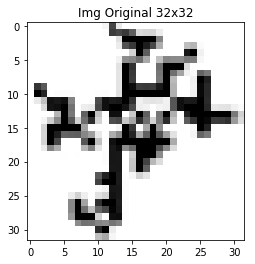

In [13]:
i = 500
img = np.reshape(X_test[i], [32, 32])

plt.figure()
plt.title('Img Original 32x32')
plt.imshow(img, cmap=cm.get_cmap('binary'))
plt.show()

/home/claudio/Documents/oil_spill/lib/python3.5/site-packages/matplotlib/image.py:383: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


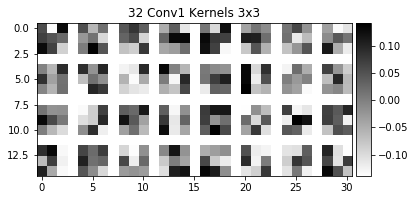

In [14]:
weight = np.asarray(model.get_weights()[0]).reshape(32, 3, 3)
plt.figure()
plt.title('32 Conv1 Kernels 3x3')
nice_imshow(plt.gca(), make_mosaic(weight, 4, 8), cmap=cm.get_cmap('binary'))
plt.show()

/home/claudio/Documents/oil_spill/lib/python3.5/site-packages/matplotlib/image.py:381: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


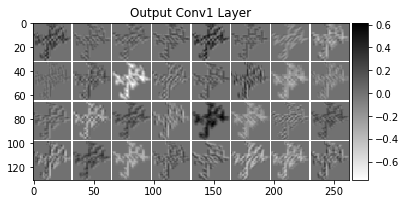

In [15]:
conv_imgs = []
for i in range(32):
    conv_imgs.append(signal.convolve2d(img, weight[i], mode='same'))
conv_imgs = np.asarray(conv_imgs)

plt.figure()
plt.title('Output Conv1 Layer')
nice_imshow(plt.gca(), make_mosaic(conv_imgs, 4, 8), cmap=cm.get_cmap('binary'))
plt.show()

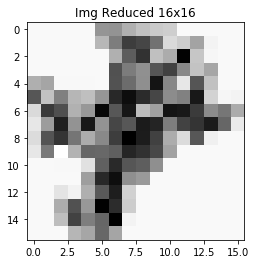

In [16]:
# maxpooling
conv_imgs_pool = []
for i in range(32):
    conv_imgs_pool.append(skimage.measure.block_reduce(conv_imgs[i], (2, 2), np.max))
conv_imgs = np.asarray(conv_imgs_pool)
plt.figure()
plt.title('Img Reduced 16x16')
plt.imshow(conv_imgs[0], cmap=cm.get_cmap('binary'))
plt.show()

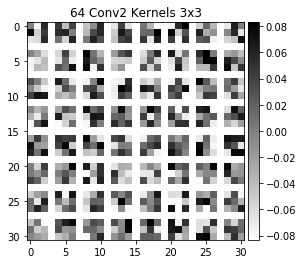

In [17]:
weight1 = np.asarray(model.get_weights()[2]).reshape(32, 64, 3, 3)
plt.figure()
plt.title('64 Conv2 Kernels 3x3')
nice_imshow(plt.gca(), make_mosaic(weight1[0], 8, 8), cmap=cm.get_cmap('binary'))
plt.show()

/home/claudio/Documents/oil_spill/lib/python3.5/site-packages/matplotlib/image.py:381: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min
/home/claudio/Documents/oil_spill/lib/python3.5/site-packages/matplotlib/image.py:383: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


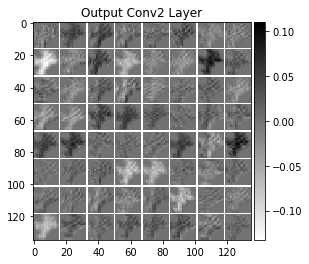

In [19]:
conv2_imgs = []
for i in range(64):
    conv2_imgs.append(signal.convolve2d(conv_imgs[0], weight1[0, i], mode='same'))

conv2_imgs = np.asarray(conv2_imgs)
plt.figure()
plt.title('Output Conv2 Layer')
nice_imshow(plt.gca(), make_mosaic(conv2_imgs, 8, 8), cmap=cm.get_cmap('binary'))
plt.show()

##### Considerazioni

Dai risultati ottenuti possiamo concludere che, utilizzando il dataset con i _tag_ associati si hanno dei risultati non del tutto confortanti e questo può essere dovuto essenzialmente a :
1. la rete non riesce ad apprendere come poter classificare le immagini per rispettare al meglio la classificazione precedente effettuata da un esperto;
2. la classificazione effettuata ha errori evidenti che deviano l'apprendimento della rete;
3. l'andamento della rete non rassicurante potrebbe essere letto come un indice del grado di inaffidabilità della precedente assegnazione dei _tag_ e quindi restituisce previsioni non congrue. 

Cambiando topologia di rete e utilizzando una _Deep Convolutional Neural Network_ possiamo osservare che utilizzando il dataset con i medesimi _tag_ del caso numerico i risultati non si discostano di molto da quelli ottenuto dalla _Neural Network_ questo conferma quanto detto in precedenza. 
Sostituendo il dataset con quello generato attravero una rete _Unsupervised_ si osserva che i risultati ottenuti sono decisamente migliori e congrui con le aspettative. Questo è confortante soprattutto nell'ottica di addestrare una rete atta alla classificazione di tre gradi di pericolosità. Con i dati in nostro possesso si potrebbe realizzare un'architettura di rete con due parti fondamentali:
1. la prima parte che possiamo identificare come _pre-classificazione_ è realizzata dalla rete _Unsupervided_ per come noi l'abbiamo ideata e descritta in seguito;
2. la seconda parte realizzata da una rete _Convoluzionale_ che ha come input quello stato precedete e che quindi posso al meglio generalizzare l'apprendimenti. 

Come sarà evidenziato nel _notebook_ sulla rete _Unsupervised_ basarci sulla clusterizzazione effettuata da questa rete non può essere considerato sufficente affincè il sistesma possa essere impiegato nell'ambito pratico. L'utilizzo della rete convoluzionale è strettamente consigliato per raffinare la classificazione in tre classi della macchie di petrolio.

<!--bibtex

@INPROCEEDINGS{7326627, 
    author={C. Bentes and D. Velotto and S. Lehner}, 
    booktitle={2015 IEEE International Geoscience and Remote Sensing Symposium (IGARSS)}, 
    title={Target classification in oceanographic SAR images with deep neural networks: Architecture and initial results}, 
    year={2015}, 
    volume={}, 
    number={}, 
    pages={3703-3706}, 
    keywords={image classification;neural nets;object detection;oceanographic techniques;radar imaging;remote sensing by radar;synthetic aperture radar;DNN;Deep Neural Networks;SAR image classification;SAR satellite;back-propagation;deep neural networks;gradient-based training algorithm;hidden layer;human operators;man-made floating structure;ocean surface structure;oceanographic SAR image analysis;oceanographic-object classification;output layer;overall network complexity;remote sensing image;shallow feed-forward neural network;synthetic aperture radar;target classification;Biological neural networks;Convolutional codes;Marine vehicles;Noise reduction;Synthetic aperture radar;Training;Automatic Target Identification;Deep Neural Networks;Machine Learning;SAR Oceanography}, 
    doi={10.1109/IGARSS.2015.7326627}, 
    ISSN={2153-6996}, 
    month={July}
}

@INPROCEEDINGS{7326163, 
    author={A. B. Salberg}, 
    booktitle={2015 IEEE International Geoscience and Remote Sensing Symposium (IGARSS)}, 
    title={Detection of seals in remote sensing images using features extracted from deep convolutional neural networks}, 
    year={2015}, 
    volume={}, 
    number={}, 
    pages={1893-1896}, 
    keywords={feature extraction;geophysical image processing;image classification;neural nets;remote sensing;support vector machines;zoology;ImageNet database;adult harp seal;aerial remote sensing image;automatic seal detection;deep convolutional neural networks;false object detection;feature extraction;linear SVM;object recognition task;seal classification;seal pup;support vector machine;Accuracy;Agriculture;Databases;Feature extraction;Remote sensing;Seals;Support vector machines;Object detection;convolutional neural networks;deep learning;detection of seals}, 
    doi={10.1109/IGARSS.2015.7326163}, 
    ISSN={2153-6996}, 
    month={July}
}

@article{DBLP:journals/corr/SimonyanZ14a,
  author    = {Karen Simonyan and
               Andrew Zisserman},
  title     = {Very Deep Convolutional Networks for Large-Scale Image Recognition},
  journal   = {CoRR},
  volume    = {abs/1409.1556},
  year      = {2014},
  url       = {http://arxiv.org/abs/1409.1556},
  archivePrefix = {arXiv},
  eprint    = {1409.1556},
  timestamp = {Wed, 07 Jun 2017 14:41:51 +0200},
  biburl    = {http://dblp.org/rec/bib/journals/corr/SimonyanZ14a},
  bibsource = {dblp computer science bibliography, http://dblp.org}
}

@article{DBLP:journals/corr/HendersonR17,
  author    = {Ryan Henderson and
               Rasmus Rothe},
  title     = {Picasso: {A} Neural Network Visualizer},
  journal   = {CoRR},
  volume    = {abs/1705.05627},
  year      = {2017},
  url       = {http://arxiv.org/abs/1705.05627},
  archivePrefix = {arXiv},
  eprint    = {1705.05627},
  timestamp = {Wed, 07 Jun 2017 14:40:57 +0200},
  biburl    = {http://dblp.org/rec/bib/journals/corr/HendersonR17},
  bibsource = {dblp computer science bibliography, http://dblp.org}
}

@article{KERAMITSOGLOU2006640,
    title = "Automatic identification of oil spills on satellite images",
    journal = "Environmental Modelling & Software",
    volume = "21",
    number = "5",
    pages = "640 - 652",
    year = "2006",
    issn = "1364-8152",
    doi = "https://doi.org/10.1016/j.envsoft.2004.11.010",
    url = "http://www.sciencedirect.com/science/article/pii/S1364815204003275",
    author = "Iphigenia Keramitsoglou and Constantinos Cartalis and Chris T. Kiranoudis",
    keywords = "Oil spills, SAR, Remote sensing, Sea surface, Marine pollution, Fuzzy logic"
}

@article{DBLP:journals/corr/ClevertUH15,
  author    = {Djork-Arné Clevert and
               Thomas Unterthiner and
               Sepp Hochreiter},
  title     = {Fast and Accurate Deep Network Learning by Exponential Linear Units
               (ELUs)},
  journal   = {CoRR},
  volume    = {abs/1511.07289},
  year      = {2015},
  url       = {http://arxiv.org/abs/1511.07289},
  archivePrefix = {arXiv},
  eprint    = {1511.07289},
  timestamp = {Wed, 07 Jun 2017 14:40:17 +0200},
  biburl    = {http://dblp.org/rec/bib/journals/corr/ClevertUH15},
  bibsource = {dblp computer science bibliography, http://dblp.org}
}

@article{DBLP:journals/corr/WongGSM16,
  author    = {Sebastien C. Wong and
               Adam Gatt and
               Victor Stamatescu and
               Mark D. McDonnell},
  title     = {Understanding data augmentation for classification: when to warp?},
  journal   = {CoRR},
  volume    = {abs/1609.08764},
  year      = {2016},
  url       = {http://arxiv.org/abs/1609.08764},
  archivePrefix = {arXiv},
  eprint    = {1609.08764},
  timestamp = {Wed, 07 Jun 2017 14:40:22 +0200},
  biburl    = {http://dblp.org/rec/bib/journals/corr/WongGSM16},
  bibsource = {dblp computer science bibliography, http://dblp.org}
}

-->

# References

<a name="cite-dblp:journals/corr/clevertuh15"/><sup>[^](#ref-1) </sup>Djork-Arné Clevert and
               Thomas Unterthiner and
               Sepp Hochreiter. 2015. _Fast and Accurate Deep Network Learning by Exponential Linear Units
               (ELUs)_. [URL](http://arxiv.org/abs/1511.07289)

<a name="cite-dblp:journals/corr/wonggsm16"/><sup>[^](#ref-2) </sup>Sebastien C. Wong and
               Adam Gatt and
               Victor Stamatescu and
               Mark D. McDonnell. 2016. _Understanding data augmentation for classification: when to warp?_. [URL](http://arxiv.org/abs/1609.08764)

<a name="cite-dblp:journals/corr/simonyanz14a"/><sup>[^](#ref-3) </sup>Karen Simonyan and
               Andrew Zisserman. 2014. _Very Deep Convolutional Networks for Large-Scale Image Recognition_. [URL](http://arxiv.org/abs/1409.1556)

<a name="cite-7326627"/><sup>[^](#ref-4) </sup>C. Bentes and D. Velotto and S. Lehner. 2015. _Target classification in oceanographic SAR images with deep neural networks: Architecture and initial results_.

<a name="cite-7326163"/><sup>[^](#ref-5) </sup>A. B. Salberg. 2015. _Detection of seals in remote sensing images using features extracted from deep convolutional neural networks_.

<a name="cite-keramitsoglou2006640"/><sup>[^](#ref-6) </sup>Iphigenia Keramitsoglou and Constantinos Cartalis and Chris T. Kiranoudis. 2006. _Automatic identification of oil spills on satellite images_. [URL](http://www.sciencedirect.com/science/article/pii/S1364815204003275)

<a name="cite-dblp:journals/corr/hendersonr17"/><sup>[^](#ref-7) </sup>Ryan Henderson and
               Rasmus Rothe. 2017. _Picasso: A Neural Network Visualizer_. [URL](http://arxiv.org/abs/1705.05627)

